## Действия и события влияющие на эффективность схем защиты

Описание:

pff_passCoverage хранит информацию о схемах которые используются в защите. Я хочу сравнить данные и выяснить, как на результативность перечисленных схем влияют:  

* (Hit) Удар защитника 
* (Hurry) Когда квотербеки, боясь назревающих объятий с защитником, в спешке бросают пас. Мяч может улететь в аут или даже в поле, главное, что пас получился не спланированным, а поспешным. В таком случае, если защитник не успел сделать сэк, он может зачислить себе hurry. Любой непродуманный пас может привести к перехвату, чего и добиваются защитники  
* (Sack) Cитуация, при которой защитнику удается свалить квотербека на газон до того, как тот бросит пас или избавится от мяча. Как правило, приводит к потере ярдов атакующей командой


А также 
- типы блоков которые применяют нападающие;  
- количество защитников около схватки;  
- результат паса;


Цель: 

- установить какие действия и события наиболее влияют на схему игры

In [643]:
import pandas as pd

import math

import sklearn

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error

from numpy.random import RandomState
state = RandomState(12345)

from tqdm import tqdm

import plotly.express as px

from sklearn.preprocessing import OrdinalEncoder 

from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

from sklearn.model_selection import train_test_split

from sklearn.metrics import  RocCurveDisplay, ConfusionMatrixDisplay,confusion_matrix,precision_score, recall_score,classification_report, f1_score,accuracy_score

## Изучение данных

Необходимая для изучения информация храниться в датафремах 

- 'pffScoutingData'  
- 'players'  
- 'plays'  

Изучим их качество и скорректируем при необходимости - убрав лишние данные; заполнив пропуски и изменив типы данных (если понадобится)

In [644]:
pffScoutingData = pd.read_csv('pffScoutingData.csv')
pffScoutingData.head(2)

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [645]:
players = pd.read_csv('players.csv')
players.head(2)

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger


In [646]:
plays = pd.read_csv('plays.csv')
plays.head(2)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone


## Предобработка сводной таблицы:

Из датафреймов Plays и pffScoutingData выберем необходимые метрики и признаки и объединим их в новую таблицу 

In [647]:
# Объединяем таблицы:

data_united = pffScoutingData.merge(plays, on=['gameId','playId']) 
data_united.head(2)

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man


In [648]:
# Удалю те столбцы, которые не информативны для исследования (данные по нападающим):

data_united = data_united.drop(columns = ['nflId','pff_role','pff_positionLinedUp','pff_hitAllowed',
                              'pff_hurryAllowed','pff_sackAllowed','pff_nflIdBlockedPlayer','pff_backFieldBlock',
                              'playDescription','quarter','down','yardsToGo','possessionTeam',
                              'defensiveTeam','yardlineSide','yardlineNumber','gameClock','preSnapHomeScore',
                              'preSnapVisitorScore','penaltyYards','prePenaltyPlayResult','playResult',
                              'foulName1','foulNFLId1','foulName2','foulNFLId2','foulName3','foulNFLId3',
                              'absoluteYardlineNumber','personnelO','personnelD','dropBackType'])

In [649]:
data_united.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188254 entries, 0 to 188253
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameId                188254 non-null  int64  
 1   playId                188254 non-null  int64  
 2   pff_hit               94127 non-null   float64
 3   pff_hurry             94127 non-null   float64
 4   pff_sack              94127 non-null   float64
 5   pff_beatenByDefender  48087 non-null   float64
 6   pff_blockType         47904 non-null   object 
 7   passResult            188254 non-null  object 
 8   offenseFormation      188100 non-null  object 
 9   defendersInBox        188100 non-null  float64
 10  pff_playAction        188254 non-null  int64  
 11  pff_passCoverage      188254 non-null  object 
 12  pff_passCoverageType  188254 non-null  object 
dtypes: float64(5), int64(3), object(5)
memory usage: 20.1+ MB


In [650]:
# выбираем метрики для исследования нового датафрейма:

DU_metrics = ['pff_passCoverage']

In [651]:
# выбираем важные признаки (влияющие на метрики)

DU_use_cat_feats = ['passResult','offenseFormation', 'passResult',
                   'pff_playAction','pff_passCoverageType','pff_hit','pff_hurry','pff_sack',]
DU_use_int_feats = ['defendersInBox']

In [652]:
data_united[DU_use_int_feats].isna().sum()

defendersInBox    154
dtype: int64

In [653]:
for col in DU_use_int_feats:
    data_united[col] = data_united[col].fillna(data_united[col].mean())

In [654]:
data_united[DU_use_int_feats].isna().sum()

defendersInBox    0
dtype: int64

In [655]:
data_united[DU_use_cat_feats].isna().sum()

passResult                  0
offenseFormation          154
passResult                  0
pff_playAction              0
pff_passCoverageType        0
pff_hit                 94127
pff_hurry               94127
pff_sack                94127
dtype: int64

In [656]:
for col in DU_use_cat_feats:
    data_united[col] = data_united[col].fillna(-1)
    data_united[col] = data_united[col].astype(str)

In [657]:
data_united[DU_use_cat_feats].isna().sum()

passResult              0
offenseFormation        0
passResult              0
pff_playAction          0
pff_passCoverageType    0
pff_hit                 0
pff_hurry               0
pff_sack                0
dtype: int64

# Выясним - влияют ли на схему защиты влияют такие обстоятельства как:

* passResult - Отброшенный результат игры ( C: Завершенный пас, I: Незавершенный пас, S: Мешок защитника, IN: Перехваченный пас, R: Схватка, текст)
* offenseFormation - Схема, используемая командой владения мячом (текст)
* pff_playAction - Индикатор того, выполняет ли нарушение подделку игрового действия в игре
* pff_passCoverageType - Был ли тип покрытия защиты человеком, зоной или другим
* pff_hit - Если игрок является защитником, индикатор того, засчитывается ли ему запись удара в этом розыгрыше
* pff_hurry - Если игрок является защитником, индикатор того, приписывают ли ему запись спешки в этой игре
* pff_sack - Если игрок является защитником, индикатор того, засчитывается ли ему запись мешка в этой игре

In [658]:
# смотрим распределение выбранной категориальной метрики (оставляем все значения)

data_united[DU_metrics].value_counts()

pff_passCoverage
Cover-3             58630
Cover-1             44242
Cover-2             23870
Quarters            22726
Cover-6             17710
Red Zone             8272
Cover-0              5940
2-Man                4400
Bracket              1034
Prevent               704
Goal Line             550
Miscellaneous         176
dtype: int64

Мы видим, что есть непопулярные признаки, которые мы объединим в общее значение OTHER: 
* Bracket
* Prevent   
* Goal Line        
* Miscellaneous 

In [659]:
# избавляемся от непопулярных (статистически малозначимых значений)

data_united[DU_metrics[0]] = data_united.apply( lambda row: row.pff_passCoverage if row.pff_passCoverage in 
                                ['Cover-3', 'Cover-1', 'Cover-2', 'Quarters','Cover-6','Red Zone','Cover-0','2-Man']
                                else 'OTHER', axis=1)

In [660]:
data_united[DU_metrics[0]].value_counts()

Cover-3     58630
Cover-1     44242
Cover-2     23870
Quarters    22726
Cover-6     17710
Red Zone     8272
Cover-0      5940
2-Man        4400
OTHER        2464
Name: pff_passCoverage, dtype: int64

## Получили самые популярные схемы используемые защитой. Теперь проверим действия которые наиболее часто применяются в схемах покрытия.

In [661]:
# То же самое сделаем с показателем 'offenseFormation':

data_united['offenseFormation'].value_counts()

SHOTGUN       120582
EMPTY          30712
SINGLEBACK     26158
I_FORM          6556
PISTOL          3388
JUMBO            660
-1               154
WILDCAT           44
Name: offenseFormation, dtype: int64

In [662]:
data_united['offenseFormation'] = data_united.apply( lambda row: row.offenseFormation if row.offenseFormation in 
                                ['SHOTGUN','EMPTY','SINGLEBACK','I_FORM','PISTOL']
                                else 'OTHER', axis=1)

array([[<AxesSubplot:title={'center':'defendersInBox'}>]], dtype=object)

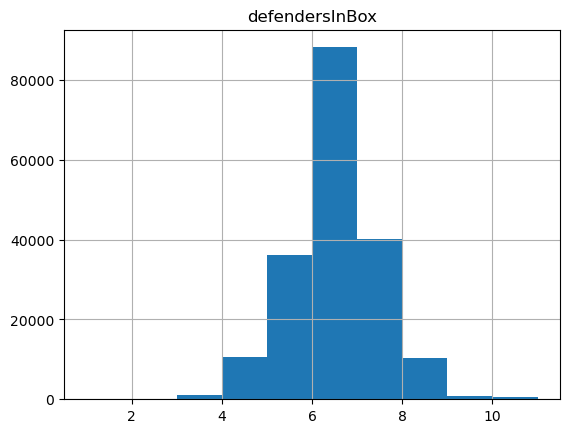

In [663]:
# Смотрим распределение количественной метрики defendersInBox:

data_united[DU_use_int_feats].hist()

In [664]:
data_united[['pff_passCoverage']+DU_use_int_feats].groupby(['pff_passCoverage']).agg(np.mean).reset_index()

,pff_passCoverage,defendersInBox
0,2-Man,5.540112
1,Cover-0,6.829630
2,Cover-1,6.088049
3,Cover-2,5.803687
4,Cover-3,6.144474
5,Cover-6,5.823602
6,OTHER,5.919842
7,Quarters,5.750264
8,Red Zone,6.316489


Мы видим, что команда защиты использует 7 защитников в непосредственной близости от линии схватки чаще всего.  

К такому методу чаще всего прибегают в схемах защиты:  

Cover-0; Cover-1; Cover-2; Cover-3; Cover-6; Quarters; Red Zone; Goal Line;


## Теперь более детально изучим влияние отдельных факторов на эффективность схемы защиты:

In [665]:
# Изучим соотношения ключевой метрики с категориальными признаками:

data_united[['pff_passCoverage'] + DU_use_cat_feats]

,pff_passCoverage,passResult,offenseFormation,passResult,pff_playAction,pff_passCoverageType,pff_hit,pff_hurry,pff_sack
0,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
1,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
2,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
3,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
4,Cover-1,I,SHOTGUN,I,0,Man,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...
188249,Quarters,S,SHOTGUN,S,0,Zone,-1.0,-1.0,-1.0
188250,Quarters,S,SHOTGUN,S,0,Zone,0.0,0.0,0.0
188251,Quarters,S,SHOTGUN,S,0,Zone,-1.0,-1.0,-1.0
188252,Quarters,S,SHOTGUN,S,0,Zone,0.0,0.0,0.0


In [666]:
data_united['passResult'].value_counts()

C     101640
I      60610
S      11946
R       9878
IN      4180
Name: passResult, dtype: int64

В важном признаке 'passResult' мы видим распределение значений:  
C - 101640 - Завершенный пас  
I - 60610 - Незавершенный пас  
S - 11946 - Мешок защитника  
R - 9878 - Схватка  
IN - 4180 - Перехваченный пас  

Text(0.5, 1.0, 'pff_passCoverage')

<AxesSubplot:title={'center':'pff_passCoverage'}>

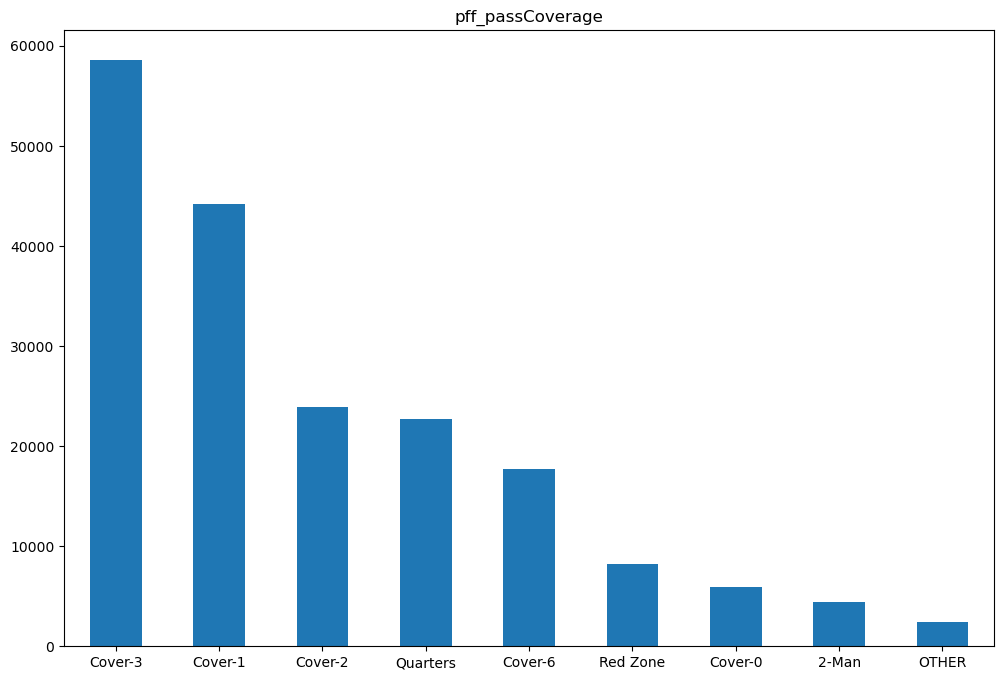

Text(0.5, 1.0, 'passResult')

<AxesSubplot:title={'center':'passResult'}>

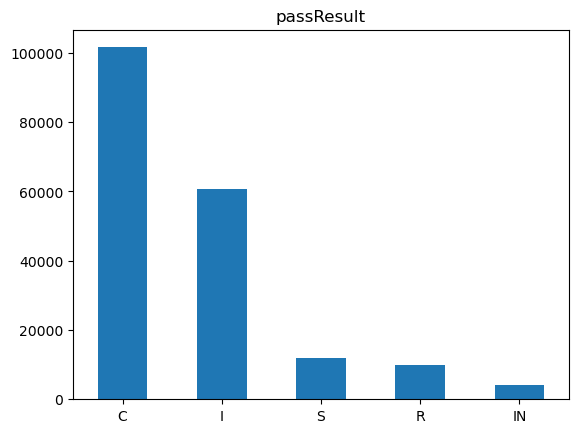

Text(0.5, 1.0, 'offenseFormation')

<AxesSubplot:title={'center':'offenseFormation'}>

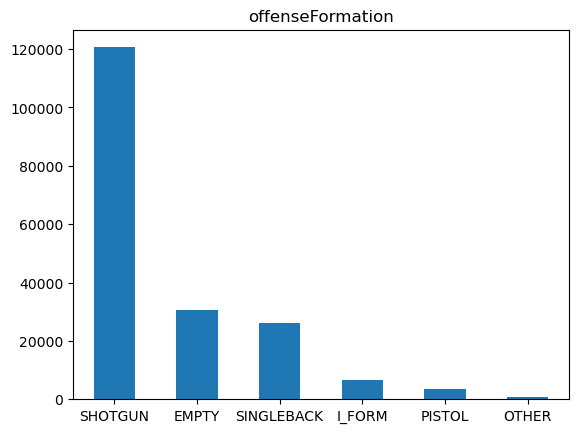

Text(0.5, 1.0, 'passResult')

<AxesSubplot:title={'center':'passResult'}>

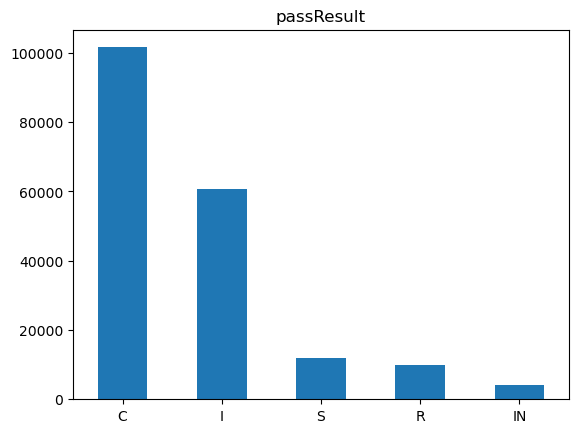

Text(0.5, 1.0, 'pff_playAction')

<AxesSubplot:title={'center':'pff_playAction'}>

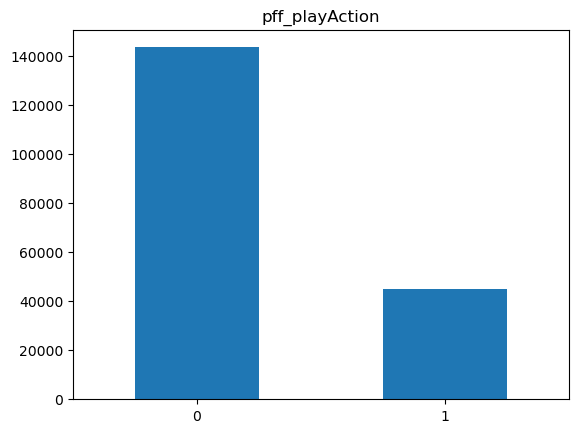

Text(0.5, 1.0, 'pff_passCoverageType')

<AxesSubplot:title={'center':'pff_passCoverageType'}>

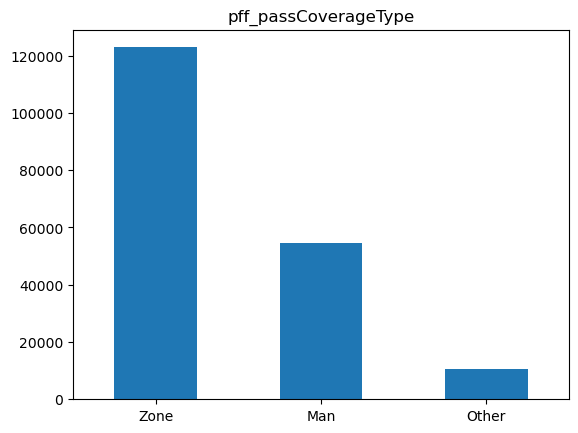

Text(0.5, 1.0, 'pff_hit')

<AxesSubplot:title={'center':'pff_hit'}>

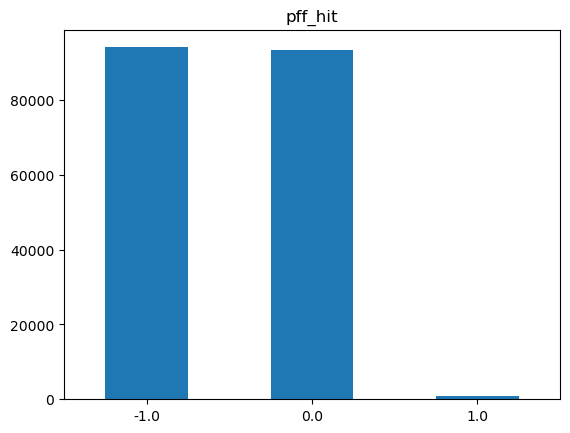

Text(0.5, 1.0, 'pff_hurry')

<AxesSubplot:title={'center':'pff_hurry'}>

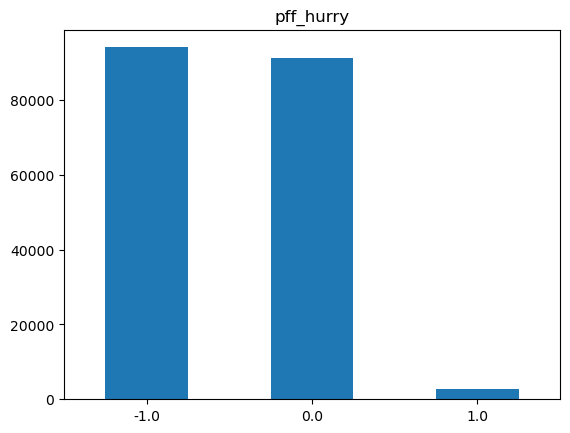

Text(0.5, 1.0, 'pff_sack')

<AxesSubplot:title={'center':'pff_sack'}>

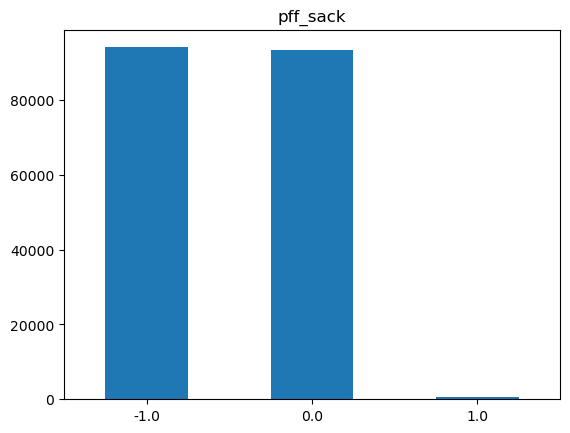

In [667]:
# Изучим распределение всех категоральных признаков:

figure,ax = plt.subplots(figsize=(12,8))
for item in ['pff_passCoverage']+DU_use_cat_feats:
    ax = plt.subplot()
    ax.set_title(item)
    data_united[item].value_counts().plot.bar(rot=0)
    plt.show()

Здесь мы видим, что:

* 'pff_passCoverage' - самой популярной схемой защиты является: Cover -3 далее идет Cover - 1, после   
Схемы Cover - 2, Quartes, Cover - 6 применяются но не так часто
Схемы Red Zone, Cover - 0, 2-Man и другие наименее полпулярны.  

Стоит отметить, что Cover - 1 считается максимально агрессивной стратегией, а Cover - 3 наиболее энергозатратной как для защиты так и для нападения. Вероятно стратегическая уникальность и делает их максимально эффективными и полпулярными.


* 'passResult' - график также подтверждает, что С (завершенный пасс) самое частое значение в итоговых данных сезона 2021 года, что положительно характеризует выбор стратегии защиты

* 'offenseFormation' - эта метрика указывает на выбор схемы, которую испльзует команда владеющая мячом. Лидер SHOTGUN - построение, при котором квотэрбэк находится в 5 ярдах от центра  

* 'playAction' - указывает, что подделка действия, прием который защитники используют в HURRY не так популярен  

* 'passCoverageType' - лидирует зональный тип защиты. К нему относятся схемы защиты: Cover - 1; Cover - 2; Cover - 3; Cover - 6  и Cover - 0  

* Прием Hit - используется в защите нечасто
* Прием Hurry - используется в защите нечасто  
* Прием Sack - используется в защите нечасто

In [668]:
DU_dummies = pd.get_dummies(data_united[DU_use_cat_feats])
DU_dummies['defendersInBox'] = data_united['defendersInBox']
DU_dummies['pff_passCoverage'] = data_united['pff_passCoverage']
DU_dummies_grp = DU_dummies.groupby(['pff_passCoverage']).agg(np.mean).reset_index()

In [669]:
DU_dummies_grp

,pff_passCoverage,passResult_C,passResult_I,passResult_IN,passResult_R,passResult_S,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_OTHER,offenseFormation_PISTOL,...,pff_hit_-1.0,pff_hit_0.0,pff_hit_1.0,pff_hurry_-1.0,pff_hurry_0.0,pff_hurry_1.0,pff_sack_-1.0,pff_sack_0.0,pff_sack_1.0,defendersInBox
0,2-Man,0.455000,0.330000,0.020000,0.100000,0.095000,0.115000,0.010000,0.005000,0.000000,...,0.5,0.494091,0.005909,0.5,0.485227,0.014773,0.5,0.495455,0.004545,5.540112
1,Cover-0,0.477778,0.429630,0.018519,0.029630,0.044444,0.200000,0.025926,0.007407,0.029630,...,0.5,0.492761,0.007239,0.5,0.479125,0.020875,0.5,0.497811,0.002189,6.829630
2,Cover-1,0.464943,0.393834,0.017404,0.046743,0.077076,0.164097,0.029339,0.003978,0.010443,...,0.5,0.495027,0.004973,0.5,0.483635,0.016365,0.5,0.496022,0.003978,6.088049
3,Cover-2,0.600000,0.270968,0.024885,0.044240,0.059908,0.151152,0.036866,0.000922,0.017512,...,0.5,0.495978,0.004022,0.5,0.485589,0.014411,0.5,0.497109,0.002891,5.803687
4,Cover-3,0.586116,0.284053,0.019887,0.049906,0.060038,0.144841,0.047280,0.001501,0.024015,...,0.5,0.495787,0.004213,0.5,0.485622,0.014378,0.5,0.496913,0.003087,6.144474
5,Cover-6,0.580124,0.285714,0.029814,0.052174,0.052174,0.147826,0.033540,0.000000,0.014907,...,0.5,0.495991,0.004009,0.5,0.486618,0.013382,0.5,0.497459,0.002541,5.823602
6,OTHER,0.437500,0.348214,0.071429,0.071429,0.071429,0.160714,0.026786,0.151786,0.000000,...,0.5,0.497565,0.002435,0.5,0.482143,0.017857,0.5,0.497159,0.002841,5.919842
7,Quarters,0.551791,0.304937,0.023233,0.066796,0.053243,0.217812,0.022265,0.002904,0.018393,...,0.5,0.495600,0.004400,0.5,0.485039,0.014961,0.5,0.497316,0.002684,5.750264
8,Red Zone,0.441489,0.388298,0.026596,0.071809,0.071809,0.204787,0.029255,0.007979,0.029255,...,0.5,0.495890,0.004110,0.5,0.481141,0.018859,0.5,0.496373,0.003627,6.316489


Данная таблица показывает наглядно - что именно и как сильно влияет на эффективность схемы защиты, например: 

- На Cover-3 наибольшее влияние оказывают:  
* passResult_C - то есть завершенный пасс;  
* pff_hit_0.0; pff_hurry_0.0; pff_sack_0.0 - отсутствие защитанных нарушений от защитника
* defendersInBox - количество защитников на линии схватки > 6

## Обучим модель предсказывать эффективность схемы защиты из расчета имеющихся факторов

Для этого подготовим данные

In [670]:
#est.fit_transform(data_united[['defendersInBox']]).toarray()

In [671]:
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

for col in ['defendersInBox']:
    data_united[col] = est.fit_transform(data_united[[col]])

In [672]:
DU_dummies= DU_dummies.drop(columns=['defendersInBox'])

In [673]:
DU_dummies_def = pd.get_dummies(data_united['defendersInBox'])
DU_dummies_def.columns=[str(int(col)) +'_defendersInBox' for col in DU_dummies_def.columns]
DU_dummies_results = pd.concat([DU_dummies,DU_dummies_def],axis=1)
DU_dummies_results.head(4)

,passResult_C,passResult_I,passResult_IN,passResult_R,passResult_S,offenseFormation_EMPTY,offenseFormation_I_FORM,offenseFormation_OTHER,offenseFormation_PISTOL,offenseFormation_SHOTGUN,...,pff_hurry_0.0,pff_hurry_1.0,pff_sack_-1.0,pff_sack_0.0,pff_sack_1.0,pff_passCoverage,0_defendersInBox,1_defendersInBox,2_defendersInBox,3_defendersInBox
0,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0
3,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,Cover-1,0,0,1,0


In [674]:
df_train, df_test = train_test_split(DU_dummies_results, test_size = 0.25)

In [675]:
target_train = df_train.pff_passCoverage.values
features_train = df_train.drop(columns = ['pff_passCoverage'])

target_test = df_test.pff_passCoverage.values
features_test = df_test.drop(columns = ['pff_passCoverage'])

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train) 

LogisticRegression(max_iter=1000, random_state=12345)

In [676]:
model.classes_

array(['2-Man', 'Cover-0', 'Cover-1', 'Cover-2', 'Cover-3', 'Cover-6',
       'OTHER', 'Quarters', 'Red Zone'], dtype=object)

# Смотрим как схемы защиты реагируют на элементы игры

In [677]:
# model.coef_[0]
feats = pd.DataFrame(model.coef_.T)
feats['feat'] = features_train.columns
feats.columns =np.concatenate([ model.classes_,['feat']])
feats.sort_values(by=['Cover-3'], ascending= False)
feats

,2-Man,Cover-0,Cover-1,Cover-2,Cover-3,Cover-6,OTHER,Quarters,Red Zone,feat
20,-3.505303,-3.504568,-4.202938,4.534364,5.097116,4.276236,-3.327380,4.548245,-3.915772,pff_passCoverageType_Zone
10,0.078415,-0.075260,0.117099,0.137723,0.317348,0.297698,-0.826601,-0.422402,0.375979,offenseFormation_SINGLEBACK
17,-0.692281,-0.010853,0.249405,0.136257,0.224137,-0.038052,-0.268040,0.265406,0.134021,pff_playAction_1
7,1.251558,-1.027526,-0.277850,0.047669,0.198262,-1.610835,1.445561,1.033784,-1.060622,offenseFormation_OTHER
30,1.280357,-1.630414,0.140505,0.174064,0.195610,-0.619534,1.216336,0.412567,-1.169490,0_defendersInBox
8,-1.884443,1.295447,0.305826,0.061674,0.193553,0.255784,-1.265123,-0.019900,1.057183,offenseFormation_PISTOL
6,0.510514,-0.671439,0.116743,0.125594,0.113180,0.388435,0.142072,-0.599723,-0.125376,offenseFormation_I_FORM
11,-0.147906,0.060832,0.005172,0.090631,0.111200,0.006319,-0.114197,0.012653,-0.024703,passResult_C
0,-0.147906,0.060832,0.005172,0.090631,0.111200,0.006319,-0.114197,0.012653,-0.024703,passResult_C
32,-0.317935,0.269326,0.573336,-0.101294,0.109421,0.282290,-1.526255,-0.124299,0.835411,2_defendersInBox


,2-Man,Cover-0,Cover-1,Cover-2,Cover-3,Cover-6,OTHER,Quarters,Red Zone,feat
0,-0.147906,0.060832,0.005172,0.090631,0.111200,0.006319,-0.114197,0.012653,-0.024703,passResult_C
1,-0.147438,0.140209,0.078456,-0.026367,0.041869,-0.063995,-0.084566,0.002038,0.059794,passResult_I
2,-0.082627,0.013046,-0.031471,0.033493,-0.049275,0.059404,0.182722,-0.012215,-0.113076,passResult_IN
3,0.121337,-0.144513,-0.029669,-0.069628,0.002675,-0.024482,-0.026649,0.123126,0.047805,passResult_R
4,0.046763,-0.148071,0.083621,0.044838,0.086941,-0.104840,0.043464,-0.030259,-0.022457,passResult_S
5,-0.543015,0.593185,-0.065824,-0.211745,-0.298968,0.180623,0.057399,0.214780,0.073564,offenseFormation_EMPTY
6,0.510514,-0.671439,0.116743,0.125594,0.113180,0.388435,0.142072,-0.599723,-0.125376,offenseFormation_I_FORM
7,1.251558,-1.027526,-0.277850,0.047669,0.198262,-1.610835,1.445561,1.033784,-1.060622,offenseFormation_OTHER
8,-1.884443,1.295447,0.305826,0.061674,0.193553,0.255784,-1.265123,-0.019900,1.057183,offenseFormation_PISTOL
9,0.377100,-0.192904,-0.089886,-0.087950,-0.329966,0.360702,0.447466,-0.111197,-0.373364,offenseFormation_SHOTGUN


In [678]:
pred_model = model.predict(features_test)
accuracy_score(target_test,pred_model)

0.5952532721400646

Точность модели не так высока, как хотелось бы - но с учетом разнообразия факторов в данных отнесусь к ней с доверием

In [633]:
#cm = confusion_matrix(target_test, pred_model)

In [679]:
print(classification_report(target_test, pred_model))


              precision    recall  f1-score   support

       2-Man       0.00      0.00      0.00      1060
     Cover-0       0.90      0.05      0.10      1479
     Cover-1       0.82      1.00      0.90     11098
     Cover-2       0.00      0.00      0.00      6008
     Cover-3       0.48      1.00      0.64     14640
     Cover-6       0.00      0.00      0.00      4467
       OTHER       0.81      0.37      0.51       608
    Quarters       1.00      0.00      0.00      5676
    Red Zone       0.84      0.97      0.90      2028

    accuracy                           0.60     47064
   macro avg       0.54      0.38      0.34     47064
weighted avg       0.54      0.60      0.46     47064



In [683]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=3)

In [684]:
pred_model = model.predict(features_test)
accuracy_score(target_test,pred_model)

0.591386197518273

<Figure size 1600x1200 with 0 Axes>

[Text(0.5, 0.875, 'pff_passCoverageType_Man <= 0.5\ngini = 0.805\nsamples = 141190\nvalue = [3340, 4461, 33144, 17862, 43990, 13243, 1856, 17050\n6244]'),
 Text(0.25, 0.625, 'pff_passCoverageType_Other <= 0.5\ngini = 0.725\nsamples = 100245\nvalue = [0, 0, 0, 17862, 43990, 13243, 1856, 17050, 6244]'),
 Text(0.125, 0.375, 'offenseFormation_SINGLEBACK <= 0.5\ngini = 0.68\nsamples = 92145\nvalue = [0, 0, 0, 17862, 43990, 13243, 0, 17050, 0]'),
 Text(0.0625, 0.125, 'gini = 0.695\nsamples = 77998\nvalue = [0, 0, 0, 15491, 35167, 11883, 0, 15457, 0]'),
 Text(0.1875, 0.125, 'gini = 0.561\nsamples = 14147\nvalue = [0, 0, 0, 2371, 8823, 1360, 0, 1593, 0]'),
 Text(0.375, 0.375, '2_defendersInBox <= 0.5\ngini = 0.353\nsamples = 8100\nvalue = [0, 0, 0, 0, 0, 0, 1856, 0, 6244]'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 2648\nvalue = [0, 0, 0, 0, 0, 0, 1319, 0, 1329]'),
 Text(0.4375, 0.125, 'gini = 0.178\nsamples = 5452\nvalue = [0, 0, 0, 0, 0, 0, 537, 0, 4915]'),
 Text(0.75, 0.625, '3_defenders

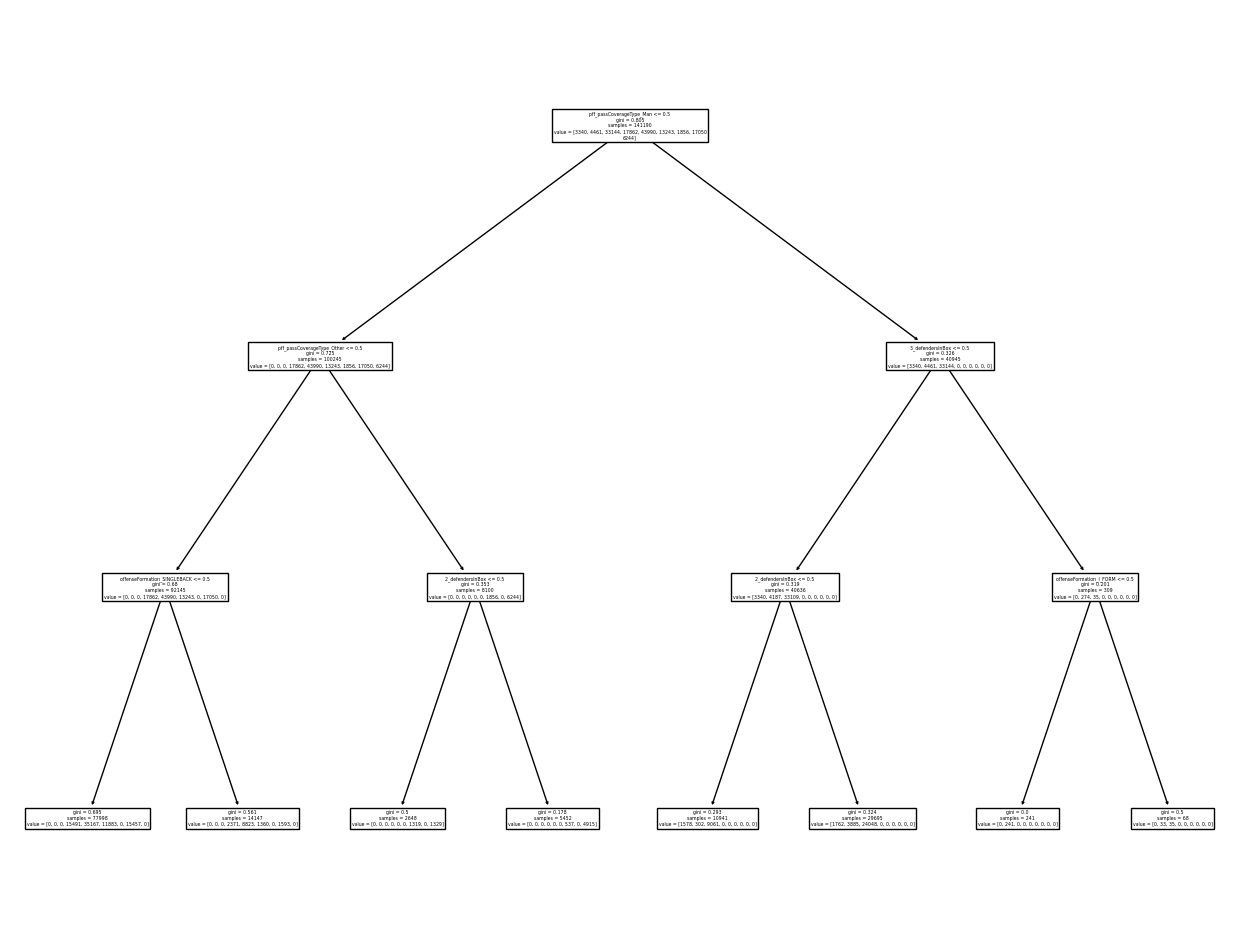

In [685]:
plt.figure(1, figsize=(16, 12))
tree.plot_tree(model,feature_names =features_train.columns)
print()

In [686]:
print(classification_report(target_test, pred_model))


              precision    recall  f1-score   support

       2-Man       0.00      0.00      0.00      1060
     Cover-0       1.00      0.05      0.09      1479
     Cover-1       0.82      1.00      0.90     11098
     Cover-2       0.00      0.00      0.00      6008
     Cover-3       0.48      1.00      0.64     14640
     Cover-6       0.00      0.00      0.00      4467
       OTHER       0.00      0.00      0.00       608
    Quarters       0.00      0.00      0.00      5676
    Red Zone       0.77      1.00      0.87      2028

    accuracy                           0.59     47064
   macro avg       0.34      0.34      0.28     47064
weighted avg       0.41      0.59      0.45     47064



## Conclusion

According to the data for the 2021 season, the choice of coaches was to use the game schemes:

Cover-3 and Cover-1

Much less frequently:

Cover - 2, Quartes, Cover - 6

Both schemes are complex, for example Cover - 1 is considered the most aggressive strategy and Cover - 3 is the most energy-consuming for both defense and attack.

So, I paid attention to the details of the game that influence these schemes, in particular from the side of the defenders. The most significant details of the game for Cover - 3 and Cover -1 were:

'passResult' - the graph also confirms that C (completed pass) is the most frequent value in the 2021 season totals, which positively characterizes the choice of defense strategy

'passCoverageType' - zonal type of protection is in the lead. It includes protection schemes: Cover - 3

Cover-3 and Cover-1 are most influenced by:

passResult_C - that is, a completed pass;
pff_hit_0.0; pff_hurry_0.0; pff_sack_0.0 - no defensive violations from defender
defendersInBox - number of defenders in the line of scrimmage > 6